In [5]:
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage.transform import resize
import math
import numpy as np
import pandas as pd
from PIL import Image
from skimage import data, exposure
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import cv2
import glob
import os

In [2]:
# self-written scripts
import sys
sys.path.insert(0, 'Python_Scripts')

import util
import surf_hog_analysis 

In [ ]:
#!pip install seaborn

In [ ]:
#!pip install imblearn

In [ ]:
#!pip install scikit-learn

---

### Data preparation

In [31]:
df = pd.read_csv('data/train_complete.csv')

In [32]:
# isolate only images that have 0 or 1 defect
util.isolate_single_defects(df)

In [34]:
# eliminate class 0 in dataframe
df2 = df.query('ClassId != 0')

---

# KNN

In [46]:
# read in and prepare augmented images for train

augmented_images =[]
augmented_labels = []
IMG_SIZE = 128
for class_id in [1,2,3,4]:
    suffix = 'c' + str(class_id)+ '/'
    directory_path = glob.glob('data/segmentation/train_aug/' + suffix)[0]
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.jpg"))):
        image_id = img_path.split('/')[-1]
        image = io.imread(img_path)
        #resize images
        image_resized=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
        #The input data have to be converted from 3 dimensional format to 1 dimensional format
        image_flat = image_resized.reshape(1, 3*IMG_SIZE*IMG_SIZE)
        # Data Normalization
        # Conversion to float
        image_flat=image_flat.astype('float32')
        # Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
        image_flat = image_flat/255.0
        augmented_images.append([image_id,image_flat[0]])
        augmented_labels.append(class_id)

In [47]:
augmented_images = pd.DataFrame(augmented_images , columns = ['ImageId', 'flattened_images'])

In [48]:
augmented_images.head()

,ImageId,flattened_images
0,aug_1000_fb0434dea.jpg,"[0.14117648, 0.14117648, 0.14117648, 0.1450980..."
1,aug_100_dcebef38e.jpg,"[0.5058824, 0.5058824, 0.5058824, 0.41568628, ..."
2,aug_101_cbba0f365.jpg,"[0.43137255, 0.43137255, 0.43137255, 0.4235294..."
3,aug_102_3b58d7324.jpg,"[0.35686275, 0.35686275, 0.35686275, 0.4235294..."
4,aug_103_5ba141d56.jpg,"[0.019607844, 0.019607844, 0.019607844, 0.0196..."


In [49]:
split_augmented_images = pd.DataFrame(augmented_images['flattened_images'].tolist())
augmented_images_complete = pd.concat([augmented_images, split_augmented_images], axis=1)
augmented_images_complete.drop(['flattened_images'], axis=1, inplace=True)

In [50]:
augmented_images_complete.head()

,ImageId,0,1,2,3,4,5,6,7,8,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,aug_1000_fb0434dea.jpg,0.141176,0.141176,0.141176,0.145098,0.145098,0.145098,0.137255,0.137255,0.137255,...,0.274510,0.227451,0.227451,0.227451,0.243137,0.243137,0.243137,0.250980,0.250980,0.250980
1,aug_100_dcebef38e.jpg,0.505882,0.505882,0.505882,0.415686,0.415686,0.415686,0.407843,0.407843,0.407843,...,0.890196,0.933333,0.933333,0.933333,0.843137,0.843137,0.843137,0.854902,0.854902,0.854902
2,aug_101_cbba0f365.jpg,0.431373,0.431373,0.431373,0.423529,0.423529,0.423529,0.580392,0.580392,0.580392,...,0.372549,0.325490,0.325490,0.325490,0.431373,0.431373,0.431373,0.384314,0.384314,0.384314
3,aug_102_3b58d7324.jpg,0.356863,0.356863,0.356863,0.423529,0.423529,0.423529,0.450980,0.450980,0.450980,...,0.039216,0.035294,0.035294,0.035294,0.015686,0.015686,0.015686,0.015686,0.015686,0.015686
4,aug_103_5ba141d56.jpg,0.019608,0.019608,0.019608,0.019608,0.019608,0.019608,0.023529,0.023529,0.023529,...,0.290196,0.290196,0.290196,0.290196,0.247059,0.247059,0.247059,0.349020,0.349020,0.349020


In [51]:
#Split in X_train and y_train
X_train = augmented_images_complete.drop(['ImageId'], axis =1)
y_train = labels

In [54]:
 y_train = pd.Series(y_train)

In [35]:
# read in and prepare images for test
initial_images =[]

IMG_SIZE = 128
for image_id in df2['ImageId']:
    image = io.imread('data/single_defect_train_images/' + image_id)
    #resize images
    image_resized=cv2.resize(image,(IMG_SIZE,IMG_SIZE))
    #The input data have to be converted from 3 dimensional format to 1 dimensional format
    image_flat = image_resized.reshape(1, 3*IMG_SIZE*IMG_SIZE)
    # Data Normalization
    # Conversion to float
    image_flat=image_flat.astype('float32')
    # Normalization (In the RGB color space the red, green and blue have integer values from 0 to 255)
    image_flat = image_flat/255.0
    initial_images.append([image_id,image_flat[0]])

In [36]:
initial_images = pd.DataFrame(initial_images , columns = ['ImageId', 'flattened_images'])

In [37]:
initial_images.head()

,ImageId,flattened_images
0,0002cc93b.jpg,"[0.28627452, 0.28627452, 0.28627452, 0.2588235..."
1,0007a71bf.jpg,"[0.19607843, 0.19607843, 0.19607843, 0.1882353..."
2,000a4bcdd.jpg,"[0.1882353, 0.1882353, 0.1882353, 0.18431373, ..."
3,000f6bf48.jpg,"[0.19215687, 0.19215687, 0.19215687, 0.3098039..."
4,0014fce06.jpg,"[0.2901961, 0.2901961, 0.2901961, 0.28627452, ..."


In [38]:
split_initial_images = pd.DataFrame(initial_images['flattened_images'].tolist())
initial_images_complete = pd.concat([initial_images, split_initial_images], axis=1)
initial_images_complete.drop(['flattened_images'], axis=1, inplace=True)

In [39]:
initial_images_complete = pd.merge(initial_images_complete, df[['ImageId','ClassId']], on='ImageId')

In [40]:
initial_images_complete.head()

,ImageId,0,1,2,3,4,5,6,7,8,...,49143,49144,49145,49146,49147,49148,49149,49150,49151,ClassId
0,0002cc93b.jpg,0.286275,0.286275,0.286275,0.258824,0.258824,0.258824,0.266667,0.266667,0.266667,...,0.219608,0.219608,0.219608,0.341176,0.341176,0.341176,0.239216,0.239216,0.239216,1
1,0007a71bf.jpg,0.196078,0.196078,0.196078,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,...,0.372549,0.372549,0.372549,0.341176,0.341176,0.341176,0.341176,0.341176,0.341176,3
2,000a4bcdd.jpg,0.188235,0.188235,0.188235,0.184314,0.184314,0.184314,0.196078,0.196078,0.196078,...,0.309804,0.309804,0.309804,0.305882,0.305882,0.305882,0.298039,0.298039,0.298039,1
3,000f6bf48.jpg,0.192157,0.192157,0.192157,0.309804,0.309804,0.309804,0.156863,0.156863,0.156863,...,0.156863,0.156863,0.156863,0.231373,0.231373,0.231373,0.196078,0.196078,0.196078,4
4,0014fce06.jpg,0.290196,0.290196,0.290196,0.286275,0.286275,0.286275,0.294118,0.294118,0.294118,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,3


In [41]:
#Split in X und Y
X = initial_images_complete.drop(['ClassId','ImageId'], axis =1)
y = initial_images_complete['ClassId']

In [42]:
y

0       1
1       3
2       1
3       4
4       3
       ..
6234    3
6235    3
6236    3
6237    3
6238    3
Name: ClassId, Length: 6239, dtype: int64

In [55]:
from sklearn.model_selection import train_test_split
X_unnötig, X_test, y_unnötig, y_test = train_test_split(X,y,test_size=0.5,stratify=y, random_state = 42)
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(4000, 49152), (4000,)
Test data and target sizes: 
(3120, 49152), (3120,)


In [56]:
test_accuracy = []
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

classifier = KNeighborsClassifier(n_neighbors=3,algorithm='brute')
classifier.fit(X_train_scaled, y_train)


y_pred = classifier.predict(X_test_scaled)
test_accuracy = classifier.score((X_test_scaled), y_test)
print(test_accuracy)

0.4810897435897436


[[ 277   29   76    3]
 [   7   90    0    0]
 [ 966  230 1039  145]
 [  74   10   79   95]]


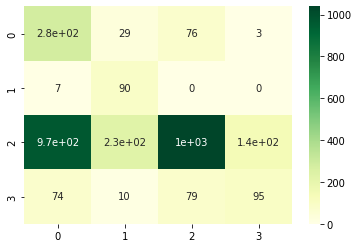

In [57]:
print(metrics.confusion_matrix(y_test,y_pred))
# Print confusion matrix
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');

In [58]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.21      0.72      0.32       385
           2       0.25      0.93      0.39        97
           3       0.87      0.44      0.58      2380
           4       0.39      0.37      0.38       258

    accuracy                           0.48      3120
   macro avg       0.43      0.61      0.42      3120
weighted avg       0.73      0.48      0.53      3120



In [59]:
proba = classifier.predict_proba(X_test_scaled)

In [60]:
pb = pd.DataFrame(proba, columns = ['class 1', 'class 2', 'class 3', 'class 4'])
pb

,class 1,class 2,class 3,class 4
0,0.333333,0.333333,0.333333,0.0
1,0.333333,0.000000,0.666667,0.0
2,1.000000,0.000000,0.000000,0.0
3,0.333333,0.000000,0.666667,0.0
4,1.000000,0.000000,0.000000,0.0
...,...,...,...,...
3115,1.000000,0.000000,0.000000,0.0
3116,1.000000,0.000000,0.000000,0.0
3117,1.000000,0.000000,0.000000,0.0
3118,0.333333,0.000000,0.666667,0.0


In [62]:
y_pred

array([1, 3, 1, ..., 1, 3, 1])

In [61]:
pd_complete = pd.concat([pb, y_test.reset_index()], axis=1)

pd_complete.head(20)

,class 1,class 2,class 3,class 4,index,ClassId
0,0.333333,0.333333,0.333333,0.000000,28,3
1,0.333333,0.000000,0.666667,0.000000,4498,3
2,1.000000,0.000000,0.000000,0.000000,3782,1
3,0.333333,0.000000,0.666667,0.000000,4683,3
4,1.000000,0.000000,0.000000,0.000000,25,1
5,0.000000,0.000000,0.666667,0.333333,1079,3
6,1.000000,0.000000,0.000000,0.000000,4267,3
7,0.000000,0.000000,1.000000,0.000000,3856,3
8,0.000000,0.000000,1.000000,0.000000,5104,3
9,0.666667,0.000000,0.333333,0.000000,4958,3


---

#### Piece-by-piece visualization

In [ ]:
# extract indices of our `hog_complete` data frame where predictions were incorrect
false_predictions = (y_pred!=y_test)
false_predictions = false_predictions[false_predictions].index.values

In [ ]:
y_pred[(y_pred!=y_test)]

In [ ]:
y_pred_false =y_pred[(y_pred!=y_test)]

predictions = pd.DataFrame(y_pred_false, index=false_predictions,columns=['ClassId_predicted'])
predictions

In [ ]:
# extract all rows from `hog_complete` where the predcition was incorrect
false_predicted_images = hog_complete.join(predictions).loc[false_predictions][['ImageId','ClassId', 'ClassId_predicted']]
# add additional information needed to find the correponding pictures
false_predicted_images = false_predicted_images.merge(df[['FilePath','ImageId']], on = 'ImageId')


In [ ]:
false_predicted_images

In [ ]:
number_images = 5

random_index = np.round(np.random.rand(number_images) * len(false_predicted_images.ImageId)) + 1
#print(random_index)

for i in range(number_images):
    #random_index = 'random_index_' + str(i+1)
    #print(random_index)
    file_path_to_image = false_predicted_images['FilePath'][random_index[i]]
    class_id = false_predicted_images['ClassId'][random_index[i]]
    image_id = false_predicted_images['ImageId'][random_index[i]]
    class_id_pred = int(false_predicted_images['ClassId_predicted'][random_index[i]])
    
    img = io.imread(file_path_to_image)
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(number_images, 1, i + 1)
    plt.imshow(img)
    plt.title(f'Image ID: {image_id} | True ClassId: {class_id} | Predicted ClassId: {class_id_pred}', fontsize=16);
    plt.axis("off")